In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform
import skimage.exposure

import sklearn.neighbors

import sys
sys.path.append("/home/jccaicedo/experimental-notebooks/tensorflow/")
import tsne

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def extract_features(im):
    im = skimage.exposure.rescale_intensity(im)
    color_hist = []
    for c in range(3):
        if len(im.shape) == 3:
            color_hist.append( np.histogram(im[:,:,c], 255)[0] )
        else:
            color_hist.append( np.histogram(im[:,:], 255)[0] )
    feat = np.concatenate(color_hist)
    feat = feat / (im.shape[0] * im.shape[1] * 3 )
    return np.expand_dims(feat, axis=0)

In [4]:
def getImage(path,zoom=0.08):
    im = skimage.io.imread(path)
    im = skimage.exposure.equalize_adapthist(im)
    return OffsetImage(im,zoom=zoom)

# Load unlabeled data

In [5]:
training_dir = "/storage/data/DSB2018/training-data/"

upaths = []
unlabeled = []

for im_name in os.listdir(training_dir):
    path = f"{training_dir}{im_name}/images/{im_name}.png"
    im = skimage.io.imread(path)
    unlabeled.append(extract_features(im))
    upaths.append(path)

# Load labeled data

In [18]:
data_dir = "/storage/data/DSB2018/"

image_groups = pd.read_csv(data_dir + "metadata/image_groups_defined_by_beth.csv")

lpaths = []
labeled = []

for i,r in image_groups.iterrows():
    path = f"{data_dir}phase-2-imgs/{r.Image}.png"
    im = skimage.io.imread(path)
    labeled.append(extract_features(im))
    lpaths.append(path)

In [7]:
categories = {}
i = 0
image_groups["Category"] = 0
for g in image_groups["Group"].unique():
    image_groups.loc[image_groups.Group == g, "Category"] = i
    categories[i] = g
    i += 1
    
categories

{0: 'Purple', 1: 'TissueBW', 2: 'PinkAndPurple', 3: 'Superbig', 4: 'Default'}

# Classify unlabeled images

In [8]:
training_samples = np.concatenate(labeled, axis=0)
training_labels = np.asarray( image_groups["Category"] )
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
neigh.fit(training_samples, image_groups["Category"]) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [9]:
test_samples = np.concatenate(unlabeled, axis=0)
predictions = neigh.predict(test_samples)

In [10]:
training_samples.shape, test_samples.shape

((106, 765), (670, 765))

/home/jccaicedo/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(<matplotlib.axes._subplots.AxesSubplot at 0x7f0a2fd84d30>,
 {0: 'Purple', 1: 'TissueBW', 2: 'PinkAndPurple', 3: 'Superbig', 4: 'Default'})

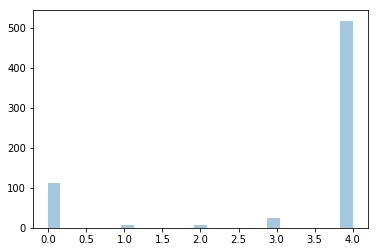

In [11]:
sb.distplot(predictions, kde=False), categories

# Visualize training set

In [12]:
Y = tsne.tsne(X=test_samples)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  670 ...
Computing P-values for point  500  of  670 ...
Mean value of sigma:  0.07462369424934322
Iteration  100 : error is  12.002813209748266
Iteration  200 : error is  0.4268246537501094
Iteration  300 : error is  0.4076361000640032
Iteration  400 : error is  0.40430580608452793
Iteration  500 : error is  0.40310105301298527
Iteration  600 : error is  0.40256136735808495
Iteration  700 : error is  0.40228326604235737
Iteration  800 : error is  0.40209916312375155
Iteration  900 : error is  0.4019155920870478
Iteration  1000 : error is  0.40173025276553437


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


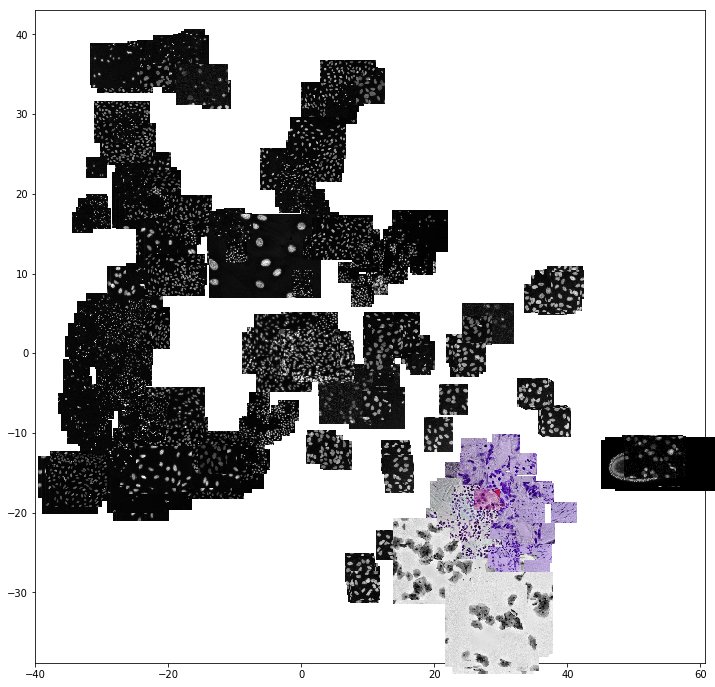

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
ax.scatter(Y[:,0], Y[:,1]) 

artists = []
for x0, y0, impath in zip(Y[:,0], Y[:,1], upaths):
    ab = AnnotationBbox(getImage(impath), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))

# Visualize test set

In [19]:
Y = tsne.tsne(X=training_samples)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  106 ...
Mean value of sigma:  0.15673007502936168
Iteration  100 : error is  10.745921882342525
Iteration  200 : error is  0.2411966630011669
Iteration  300 : error is  0.13039804647434558
Iteration  400 : error is  0.12559026064415812
Iteration  500 : error is  0.12320871734470555
Iteration  600 : error is  0.12301350355345195
Iteration  700 : error is  0.12300716493882549
Iteration  800 : error is  0.12300525140032138
Iteration  900 : error is  0.12300419828754841
Iteration  1000 : error is  0.12300360890603468


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


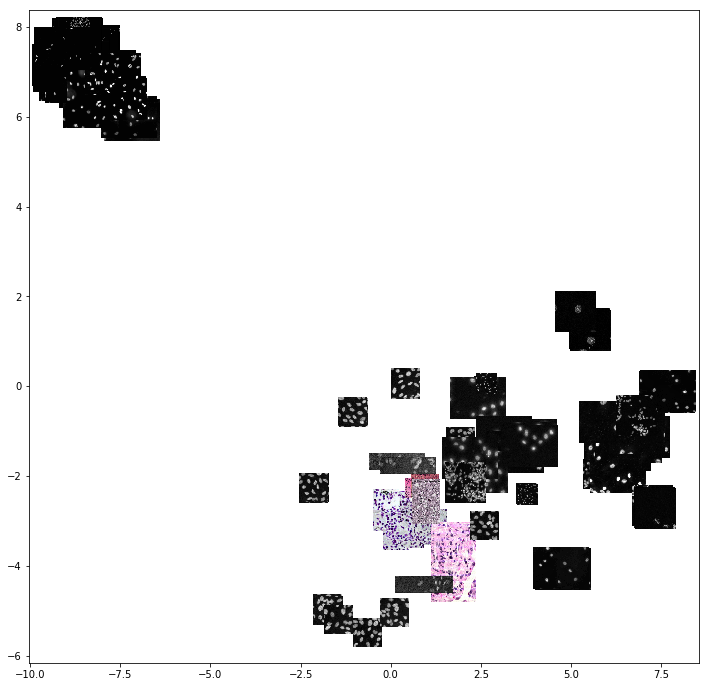

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
ax.scatter(Y[:,0], Y[:,1]) 

artists = []
for x0, y0, impath in zip(Y[:,0], Y[:,1], lpaths):
    ab = AnnotationBbox(getImage(impath), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))